In [236]:
import antropy
import numpy as np
import matplotlib.pyplot as plt
#mamba install antropy
def norris_pulse(t,t0,A,tr,r,pk):
    tn = np.array([(t0-ti) if(ti<t0) else (ti-t0) for ti in t])
    tex = np.array([tr if(ti<t0) else r*tr for ti in t])
    c = A*np.exp(-(tn/tex)**pk)
    return c
# create a function that takes a time series in input (array) and apply a rolling window to it with partially overlapped windows
# the function returns a list of time windows and array of the time series with the same length of the windows


def rolling_window(time,time_series, window_size, overlap):
    windows = []
    time_series_rolled = []
    for i in range(0, len(time_series)-window_size, window_size-overlap):
        windows.append(np.median(time[i:i+window_size]))
        time_series_rolled.append(time_series[i:i+window_size])
    return windows, time_series_rolled


# create a function that apply some function to each window of a time series
def entropy_window(time,time_series, entropy_function,params,window_size,overlap):
    windows, time_series_rolled = rolling_window(time,time_series, window_size, overlap)
    entropy_values = []
    for i in range(len(windows)):
        entropy_values.append(entropy_function(time_series_rolled[i],params))
    return windows,np.array(entropy_values)


def shannon_entropy(probas):
    return -np.sum(probas*np.log2(1e-10+probas))

def Renyi_entropy(probas,alpha):
    return np.log2(np.sum(probas**alpha))/(1-alpha)
    
def svd_entropy(time_series,params):
    order=params[0]
    delay=params[1]
    return antropy.svd_entropy(time_series, order=order, delay=delay)

def spectral_entropy(time_series,params):
    return antropy.spectral_entropy(time_series, sf=100, method='welch', normalize=True)

def _embed(x, order=3, delay=1):
    """Time-delay embedding.

    Parameters
    ----------
    x : array_like
        1D-array of shape (n_times) or 2D-array of shape (signal_indice, n_times)
    order : int
        Embedding dimension (order).
    delay : int
        Delay.

    Returns
    -------
    embedded : array_like
        Embedded time series, of shape (..., n_times - (order - 1) * delay, order)
    """
    x = np.asarray(x)
    N = x.shape[-1]
    assert x.ndim in [1, 2], "Only 1D or 2D arrays are currently supported."
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")

    if x.ndim == 1:
        # 1D array (n_times)
        Y = np.zeros((order, N - (order - 1) * delay))
        for i in range(order):
            Y[i] = x[(i * delay) : (i * delay + Y.shape[1])]
        return Y.T
    else:
        # 2D array (signal_indice, n_times)
        Y = []
        # pre-defiend an empty list to store numpy.array (concatenate with a list is faster)
        embed_signal_length = N - (order - 1) * delay
        # define the new signal length
        indice = [[(i * delay), (i * delay + embed_signal_length)] for i in range(order)]
        # generate a list of slice indice on input signal
        for i in range(order):
            # loop with the order
            temp = x[:, indice[i][0] : indice[i][1]].reshape(-1, embed_signal_length, 1)
            # slicing the signal with the indice of each order (vectorized operation)
            Y.append(temp)
            # append the sliced signal to list
        Y = np.concatenate(Y, axis=-1)
        return Y

def svd_entropy_Renyi(x,params,normalize=False):
    order=int(params[0])
    delay=int(params[1])
    alpha=params[2]
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = Renyi_entropy(W,alpha)
    if normalize:
        svd_e /= np.log2(order)
    return svd_e


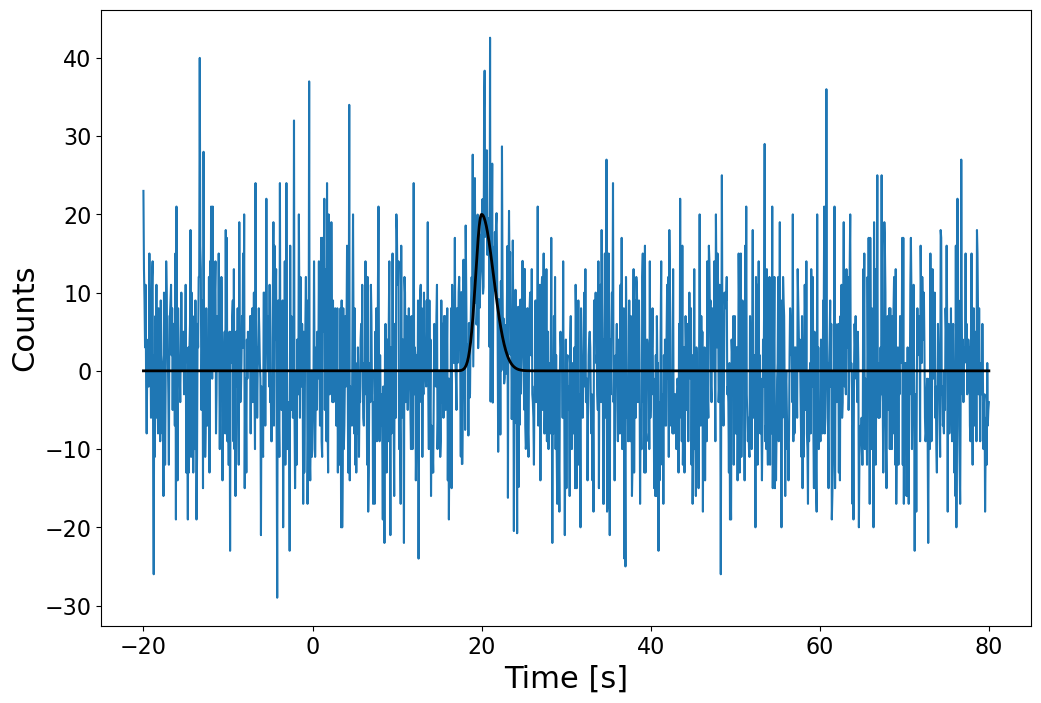

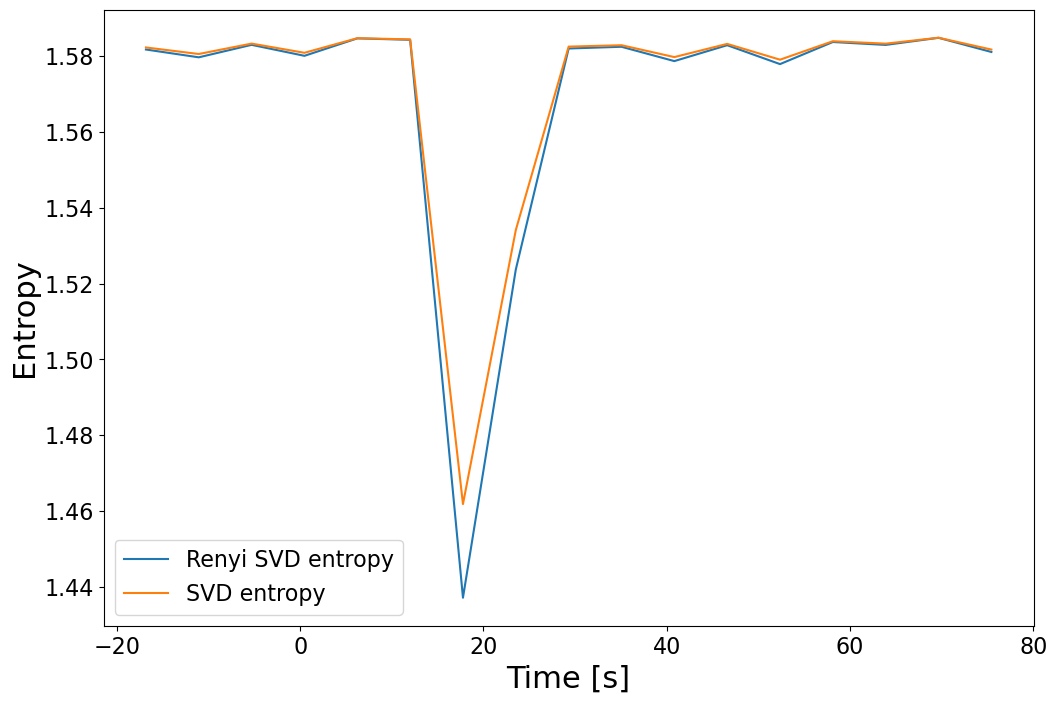

In [237]:
# create a time series
ti,tf=-20,80
bin_time=0.064
time = np.linspace(ti,tf, int((tf-ti)/bin_time))
# plot the signal from different windows
window_size = 100
overlap = 10
t0=20
A=20
tr=1
r=2
pk=2
level_noise=100
time_series =np.random.poisson(level_noise,size=len(time))-level_noise+norris_pulse(time,t0,A,tr,r,pk)

windows, time_series_rolled = rolling_window(time,time_series, window_size, overlap)

plt.figure(figsize=(12,8))

plt.plot(time, time_series, label='Original signal')
plt.plot(time, norris_pulse(time,t0,A,tr,r,pk), color='k',lw=2.)
plt.xlabel('Time [s]',size=22)
plt.ylabel('Counts',size=22)
plt.xticks(size=16)
plt.yticks(size=16)
#for i in range(len(windows)):
#    plt.plot(windows[i],time_series_rolled[i], label='Window '+str(i))
# apply a function to each window
params=np.array([3,1])

svd_entropy_values = entropy_window(time,time_series, svd_entropy, params,window_size,overlap)


plt.figure(figsize=(12,8))

plt.xlabel('Time [s]',size=22)
plt.ylabel('Entropy',size=22)
plt.xticks(size=16)
plt.yticks(size=16)

#for alpha in [1,2,6,10,20,80]:

alpha=1.2
params=np.array([3,1,alpha])
_,svd_entropy_Renyi_values = entropy_window(time,time_series, svd_entropy_Renyi, params,window_size,overlap)
plt.plot(windows,svd_entropy_Renyi_values,label='Renyi SVD entropy')
params=np.array([3,1])
_,svd_entropy_values = entropy_window(time,time_series, svd_entropy, params,window_size,overlap)
plt.plot(windows,svd_entropy_values,label='SVD entropy')
plt.legend(fontsize=16)

##
##
##

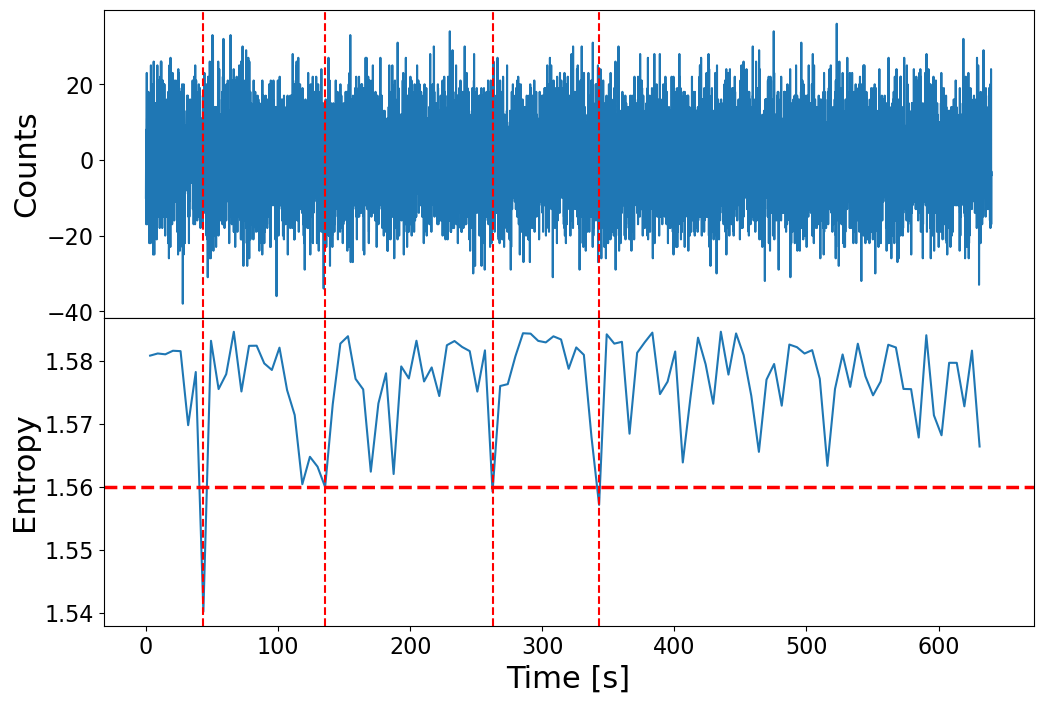

In [98]:
# create a time series with only noise of fixed length
N_pts = 10000
level = 100
bin_time = 0.064
time = np.linspace(0,bin_time*N_pts,N_pts)
noise = np.random.poisson(level,size=N_pts)-level
#plt.plot(noise)
# apply entropy to this time series
params=np.array([3,1,2])

windows,svd_entropy_noise_values = entropy_window(time,noise,svd_entropy_Renyi, params,window_size,overlap)
# do a subplot with two figures vertically with signal and entropy on different windows
#fig,axs = plt.subplots(2,1)





# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    sharex=True,  # Share the x-axis
    gridspec_kw={'hspace': 0},  # Remove vertical space
    figsize=(12, 8)  # Set the figure size (x, y)
)

# Plot on the subplots
ax1.plot(time, noise, label="Sine")
ax2.plot(windows,svd_entropy_noise_values)

# Add labels
ax2.set_xlabel("Time [s]",size=22)
ax1.set_ylabel("Counts",size=22)
ax2.set_ylabel("Entropy",size=22)

#add a threshold on the entropy
threshold = 1.56
ax2.axhline(threshold, color='r', linestyle='--', label='Threshold',lw=2.5)
# find the times for wich the entropy is lower the threshold
times = [windows[i] for i in range(len(windows)) if svd_entropy_noise_values[i]<threshold]
# plot vertical lines on the first plot for each these times
for time in times:
    ax1.axvline(time, color='r', linestyle='--', label='Entropy lower than threshold')
    ax2.axvline(time, color='r', linestyle='--', label='Entropy lower than threshold')

# adjust the size of the fonts of the labels
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)


#ax1.scatter(times,np.ones(len(times))*level, color='r', label='Entropy lower than threshold')

#ax1.scatter(times,np.ones(len(times))*level, color='r', label='Entropy lower than threshold')

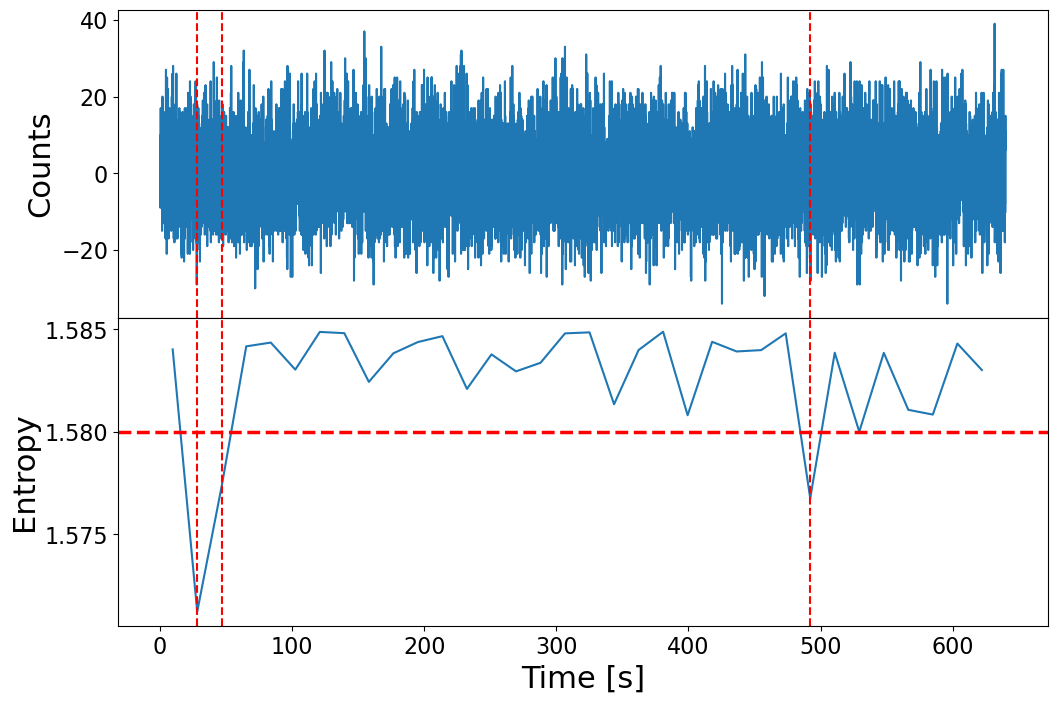

In [238]:
# create a time series with only noise of fixed length
N_pts = 10000
level = 100
bin_time = 0.064
window_size = 300
time = np.linspace(0,bin_time*N_pts,N_pts)
noise = np.random.poisson(level,size=N_pts)-level
t0,A,tr,r,pk = 300,60,3,2,2
#pulse = norris_pulse(time,t0,A,tr,r,pk)
#noise = noise + pulse 
#plt.plot(noise)
# apply entropy to this time series
params=np.array([3,1,2])

windows,svd_entropy_noise_values = entropy_window(time,noise,svd_entropy_Renyi, params,window_size,overlap)
# do a subplot with two figures vertically with signal and entropy on different windows
#fig,axs = plt.subplots(2,1)





# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    sharex=True,  # Share the x-axis
    gridspec_kw={'hspace': 0},  # Remove vertical space
    figsize=(12, 8)  # Set the figure size (x, y)
)

# Plot on the subplots
ax1.plot(time, noise, label="Sine")
#ax1.plot(time, pulse, label="Pulse",color='k',lw=2)

ax2.plot(windows,svd_entropy_noise_values)

# Add labels
ax2.set_xlabel("Time [s]",size=22)
ax1.set_ylabel("Counts",size=22)
ax2.set_ylabel("Entropy",size=22)

#add a threshold on the entropy
threshold = 1.58
ax2.axhline(threshold, color='r', linestyle='--', label='Threshold',lw=2.5)
# find the times for wich the entropy is lower the threshold
times = [windows[i] for i in range(len(windows)) if svd_entropy_noise_values[i]<threshold]
# plot vertical lines on the first plot for each these times
for time in times:
    ax1.axvline(time, color='r', linestyle='--', label='Entropy lower than threshold')
    ax2.axvline(time, color='r', linestyle='--', label='Entropy lower than threshold')

# adjust the size of the fonts of the labels
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)


#ax1.scatter(times,np.ones(len(times))*level, color='r', label='Entropy lower than threshold')

#ax1.scatter(times,np.ones(len(times))*level, color='r', label='Entropy lower than threshold')

In [239]:
# create a function that counts the number of times the entropy is lower than a threshold
def count_times_below_threshold(time,time_series, entropy_function, params, window_size, overlap, threshold):
    windows, entropy_values = entropy_window(time,time_series, entropy_function, params, window_size, overlap)
    times_fp = [windows[i] for i in range(len(windows)) if entropy_values[i]<threshold]
    return len(times_fp)/len(time_series)

# test the function on the noise time series
params=[3,1,2]
count_times_below_threshold(times,noise, svd_entropy_Renyi, params, window_size, overlap, threshold)

/home/romain/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/romain/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.0003

In [240]:
# test on a long time series:

N_pts = 10000000
level = 100
bin_time = 0.064
window_size = 100
threshold = 1.54


time = np.linspace(0,bin_time*N_pts,N_pts)
noise = np.random.poisson(level,size=N_pts)-level



t0,A,tr,r,pk = 300,60,3,2,2
#pulse = norris_pulse(time,t0,A,tr,r,pk)
#noise = noise + pulse
count_times_below_threshold(time,noise, svd_entropy_Renyi, params, window_size, overlap, threshold)


4.22e-05

In [249]:
# def a function that says if a pulse is present in the time series
def detection_TPR(times,time_series, entropy_function, params, window_size, overlap, threshold, tpulse,tolerance):
    windows, entropy_values = entropy_window(times,time_series,entropy_function,params,window_size,overlap)
    for w,e in zip(windows,entropy_values):
        if e < threshold and abs(w-tpulse)<tolerance:
            return True
    return False

False

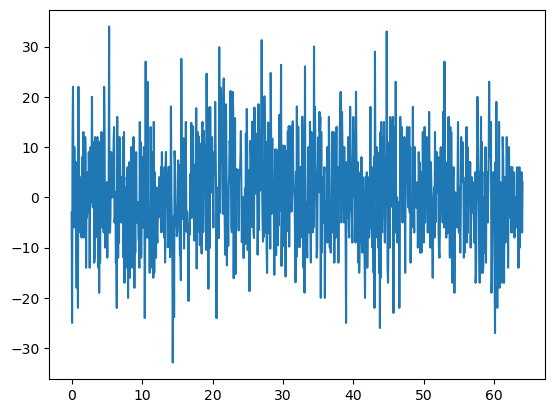

In [262]:
tpulse=300
tolerance=50
level=100
times = np.linspace(0,bin_time*N_pts,N_pts)
tpulse,A,tr,r,pk = 20,5,3,2,2

pulse = norris_pulse(time,tpulse,A,tr,r,pk)
noise = np.random.poisson(level,size=N_pts)-level
time_series = noise + pulse

plt.plot(time,time_series)
detection_TPR(times,time_series,svd_entropy_Renyi, params, window_size, overlap, threshold, tpulse,tolerance)

In [243]:
# test on a N times series containing a pulse
N_pts = 1000
level = 100
bin_time = 0.064
window_size = 100
tolerance = 50
#threshold = 1.54
time = np.linspace(0,bin_time*N_pts,N_pts)
noise = np.random.poisson(level,size=N_pts)-level
t0,A,tr,r,pk = 30,20,3,2,2
pulse = norris_pulse(time,t0,A,tr,r,pk)
signal = noise + pulse

detection_TPR(times,time_series, svd_entropy_Renyi, params, window_size, overlap, threshold, tpulse,tolerance)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


ValueError: operands could not be broadcast together with shapes (10000000,) (111110,) 